In [3]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [4]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## Load a SAM model

In [5]:
import os 

SAM_path = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/SAM/"
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=os.path.join(SAM_path, checkpoint))
device = "cuda"
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [5]:
onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

In [6]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )   

## Load sample image and mask

In [6]:
from glob2 import glob
import skimage.io as io
from matplotlib import pyplot as plt
from skimage.transform import resize

root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/"
model_name = "mask_v2_0050_predictions"
# experiment_date = "20230629"
# im_stub = "H02_t0032"
experiment_date = "20231206"
im_stub = "A09_t0041"

image_path = glob(os.path.join(root, "built_image_data", "stitched_FF_images_raw", experiment_date, im_stub + "*"))[0]
image = io.imread(image_path).T
mask_path = glob(os.path.join(root, "built_image_data", "segmentation", "20240620", model_name, experiment_date + "_" + im_stub + "*"))[0]
mask_init = io.imread(mask_path)
image = resize(image, mask_init.shape, order=1)

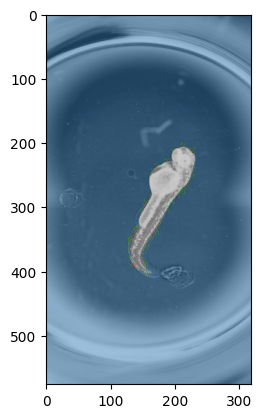

In [7]:
image_8u = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
image_in = resize(cv2.cvtColor(image_8u, cv2.COLOR_GRAY2RGB), (256, 256), order=1)
mask_prompt = resize(mask_init, (256, 256), order=0)
plt.imshow(image, cmap="gray")

plt.imshow(mask_init, cmap='Set1', alpha=0.5, interpolation='none')
# plt.axis([x.min(), x.max(), y.min(), y.max()])

plt.show()

## See if we can improve mask 

In [8]:
masks = mask_generator.generate(image_in)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 31.57 GiB of which 415.88 MiB is free. Process 2717764 has 534.79 MiB memory in use. Process 2724066 has 23.31 GiB memory in use. Including non-PyTorch memory, this process has 6.03 GiB memory in use. Of the allocated memory 4.60 GiB is allocated by PyTorch, and 1.06 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [67]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [68]:
sam.to(device='cuda')
predictor = SamPredictor(sam)

In [69]:
image_test = cv2.imread(os.path.join(SAM_path, "truck.jpg"))
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)

In [70]:
predictor.set_image(image_in)

In [71]:
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [72]:
image_embedding.shape

(1, 256, 64, 64)

In [73]:
mask_prompt = mask_prompt - np.min(mask_prompt)
mask_prompt = mask_prompt / np.max(mask_prompt)

# get ref arrays
y_ref, x_ref = np.meshgrid(range(256), range(256), indexing="ij")

# get coord pairs inside region
y_mask = y_ref[mask_prompt==1]
x_mask = x_ref[mask_prompt==1]

# draw N samples
N = 2

samp_indices = np.random.choice(np.sum(mask_prompt==1), N, replace=False)
y_samp = y_mask[samp_indices]
x_samp = x_mask[samp_indices]

# combine 
input_point = np.concatenate((x_samp[:, np.newaxis], y_samp[:, np.newaxis]), axis=1)
input_label = np.ones((input_point.shape[0],))

In [74]:
# format
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image_in.shape[:2]).astype(np.float32)
# onnx_coord = onnx_coord.astype(np.float32)
# create an empty mask
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [75]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image_in.shape[:2], dtype=np.float32)
}

masks, _, logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

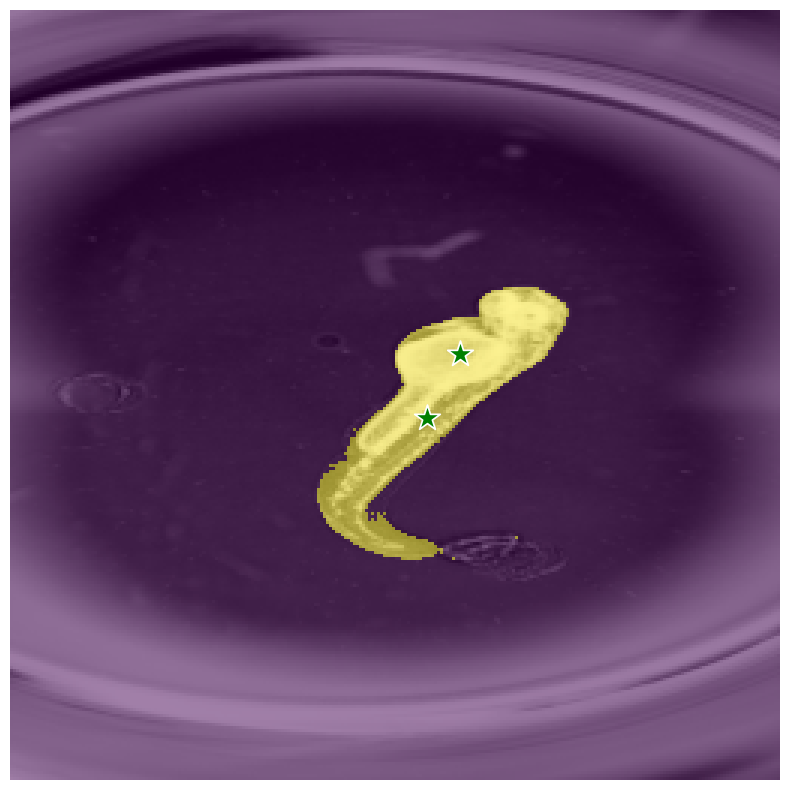

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(image_in, cmap="gray")
# show_mask(masks, plt.gca())
plt.imshow(np.squeeze(logits > 0), alpha=0.5)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

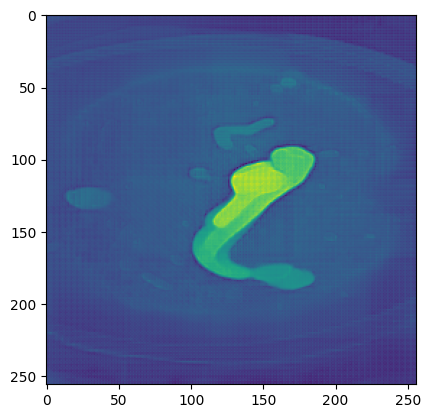

In [50]:
plt.imshow(np.squeeze(logits))
plt.show()

In [61]:
logits

array([[[[-5.7373104, -5.877802 , -5.8153396, ..., -6.712977 ,
          -6.662107 , -6.722185 ],
         [-6.014005 , -6.4136257, -5.972352 , ..., -7.411066 ,
          -7.2053127, -7.4344697],
         [-5.4205623, -5.64577  , -5.693232 , ..., -6.4337234,
          -6.3389125, -6.5110745],
         ...,
         [-5.070956 , -5.939134 , -5.1716256, ..., -7.7822323,
          -7.058845 , -7.440595 ],
         [-5.6170793, -5.974814 , -5.8350105, ..., -7.2471004,
          -7.8979936, -7.3638973],
         [-5.254835 , -6.186816 , -5.11106  , ..., -7.601645 ,
          -6.956581 , -7.4666977]]]], dtype=float32)